In [56]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from METRICS import *

In [14]:

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns
import numpy_indexed as npi


In [61]:
def build_model(model, parameters, folds, train_size, X,Y,groups_original):
    acc_scorer = make_scorer(accuracy_score)
    recalls = make_scorer(recall_score,average='micro')##buscar por que micro
    precision = make_scorer(precision_score,average='micro')
    f1 = make_scorer(f1_score,average='micro')
    scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
    gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
    model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups_original))
    model.fit(X,Y)
    return model 

In [62]:
def Metrics(model,X_test,Y_test,clases):

  y_predicted = model.predict(X_test)
  print('Accuracy: ', accuracy_score(Y_test, y_predicted), '\n')
  report = classification_report(Y_test, y_predicted)
  print("\nclassification report :\n",report )
 
  # Matriz de confusión
  cm = confusion_matrix(Y_test, y_predicted)
  # Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
    
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clases, yticklabels=clases)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
  plt.show(block=False)
  
  #sns.heatmap(cm,annot=True,fmt = "d",linecolor="k",linewidths=3)
  #plt.title("Matriz de confusión",fontsize=20)
   
    
  return report

In [63]:
def learning_curve(model,best_parameters,folds, X,Y,groups=groups, suptitle='', title='', xlabel='Training Set Size', ylabel='Acurracy'):
    """
    Parameters
    ----------
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    std_train= []
    std_val=[]

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(.1,.9,5).tolist()
    # for each one of those training set sizes
    
    for i in training_set_sizes:  
        model_trained = build_model(model=model, parameters=best_parameters, folds=folds, train_size=i, X=X,Y=Y,groups_original=groups_original)                
        EfficiencyVal= model_trained.cv_results_['mean_test_Accuracy'][model_trained.best_index_]
        EfficiencyTrain=model_trained.cv_results_['mean_train_Accuracy'][model_trained.best_index_]
        stdTrain=model_trained.cv_results_['std_train_Accuracy'][model_trained.best_index_]
        stdVal=model_trained.cv_results_['std_test_Accuracy'][model_trained.best_index_]

        # store the scores in their respective lists
        train_score.append(EfficiencyTrain)
        val_score.append(EfficiencyVal)
        std_train.append(stdTrain)
        std_val.append(stdVal)

    train_score =np.array(train_score)
    val_score =np.array(val_score)
    std_train =np.array(std_train)
    std_val =np.array(std_val)


    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')
    
    ax.fill_between(training_set_sizes,train_score+std_train,train_score-std_train,facecolor='gold',alpha=0.5)
    ax.fill_between(training_set_sizes,val_score+std_val,val_score-std_val,facecolor='steelblue',alpha=0.5)

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['Train set', 'Test set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)
    data = {'Train_Size':training_set_sizes, 'mean_train_Accuracy':train_score,'mean_test_Accuracy':val_score,'std_train_Accuracy':std_train,'std_test_Accuracy':std_val}
    df_split_params = pd.DataFrame(data)
    return df_split_params

In [21]:
PATHDATA_MFFC_AVG = '../../data/audios_MFCC_Flatten_Means.csv'
df = pd.read_csv(PATHDATA_MFFC_AVG, header = None)
clases =np.array(['yes','no','right','five','nine'])
data = df.values #Convertimos en un  numpy array
df

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,-578.183594,34.746494,-6.227449,50.076725,13.485531,20.483133,23.309504,17.892561,22.907711,19.530531,...,18.488085,16.491943,20.265697,15.504094,17.719561,16.063190,7.158887,15.391005,4.0,0.0
1,-539.838135,39.440987,-18.157864,56.610138,13.561887,27.468927,22.405123,18.649464,20.244602,15.674647,...,22.015572,11.824497,19.782654,15.595941,14.123998,15.435017,12.188399,15.958430,4.0,0.0
2,-633.009155,46.591732,31.916828,24.640398,20.384712,21.708477,21.421858,23.832544,24.445465,21.587992,...,13.741821,17.604811,20.631048,20.548290,17.002838,13.849539,13.543025,13.759918,4.0,1.0
3,-452.937225,125.244095,43.845169,91.930519,21.001598,14.252425,5.181086,23.042732,-7.787588,-7.302704,...,16.110474,12.235356,16.800062,10.826190,8.179255,7.419957,3.597054,8.044436,4.0,3.0
4,-563.710693,79.472610,35.141331,58.115299,40.987614,32.446346,15.186209,34.812389,11.014744,3.695235,...,12.510882,12.819203,13.827777,14.294342,10.434172,9.369196,9.179496,10.365860,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-539.770508,79.760132,24.791115,27.663658,17.612919,30.274504,19.307281,21.242352,15.312921,9.133543,...,13.179388,12.752730,17.898590,12.665988,10.535906,11.531238,9.660569,14.150393,1.0,609.0
4996,-539.998535,148.162888,61.355381,15.081635,11.361095,10.008124,3.340254,3.150235,6.168007,8.034798,...,3.662930,12.336813,4.206754,-6.095991,-1.812998,8.413839,12.013117,12.154606,1.0,610.0
4997,-575.798157,109.206421,40.084347,2.207824,6.494443,19.620073,16.461866,-2.157397,-21.011055,-24.194643,...,-1.410588,4.623737,-1.226568,15.206586,16.772701,3.964441,11.726809,11.859737,1.0,610.0
4998,-549.157654,131.149902,38.933079,-7.734122,-10.893186,-12.604925,-15.898232,-4.690342,14.742783,23.064165,...,-1.161046,29.092978,36.631687,21.981638,15.151622,10.731631,1.915951,6.023498,1.0,610.0


In [66]:
X = data[:,0:-3]
Y = data[:,-2]
print('Tamaño data set', X.shape)

Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-1]


Tamaño data set (5000, 199)


In [4]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 668


In [6]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
gss.get_n_splits()
for train_index, test_index in gss.split(X, Y, groups=groups):
    X_train_original, X_test__original = X[train_index], X[test_index]
    #print(X_train, X_test)
    Y_train__original, Y_test__original = Y[train_index], Y[test_index]
    #print(y_train, y_test)
    groups_original = groups[train_index]
    groups_test_original=groups[test_index]


# MLP

In [7]:
FOLDS = 10
TRAIN_SIZE = 0.8

In [8]:
from sklearn.neural_network import MLPClassifier
parameters = [{'hidden_layer_sizes': [(32,32),(36,36),(40,40)]},
{'hidden_layer_sizes': [(32,32,32),(36,36,36),(40,40,40)]},
{'hidden_layer_sizes': [(32,32,32,32),(36,36,36,36),(40,40,40,40)]}]
mlp = MLPClassifier()#Configurar el modelo
model_trained_MLP = METRICS.build_model(self=1, model=mlp, parameters=parameters,folds=FOLDS,train_size=TRAIN_SIZE, X=X_train_original,Y=Y_train__original,groups_original=groups_original)
best_params_MLP = model_trained_MLP.cv_results_['params'][model_trained_MLP.best_index_]
print(best_params_MLP)

/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'hidden_layer_sizes': (40, 40, 40, 40)}


In [9]:
params_acurracy = ['mean_train_Accuracy','mean_test_Accuracy','std_train_Accuracy','std_test_Accuracy']
best_acurracy_MLP= []
for p in params_acurracy:
    parameter_acurracy =model_trained_MLP.cv_results_[p][model_trained_MLP.best_index_]
    best_acurracy_MLP.append({p:parameter_acurracy})
print("Resultados mejor modelo: ", best_params_MLP)
best_acurracy_MLP

Resultados mejor modelo:  {'hidden_layer_sizes': (40, 40, 40, 40)}


[{'mean_train_Accuracy': 0.9915770081830482},
 {'mean_test_Accuracy': 0.7976773215343351},
 {'std_train_Accuracy': 0.009857491606200336},
 {'std_test_Accuracy': 0.012218688733500111}]

Accuracy:  0.7986501687289089 


classification report :
               precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       170
         1.0       0.64      0.76      0.69       181
         2.0       0.84      0.79      0.82       185
         3.0       0.81      0.79      0.80       189
         4.0       0.97      0.93      0.95       164

    accuracy                           0.80       889
   macro avg       0.81      0.80      0.80       889
weighted avg       0.81      0.80      0.80       889



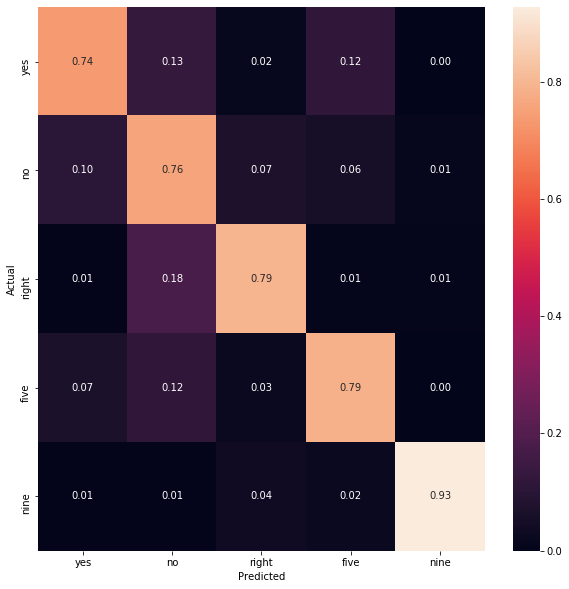

In [39]:
MLP_best_estimator = model_trained_MLP.best_estimator_
metrics = Metrics(MLP_best_estimator,X_test__original,Y_test__original,clases)
#metricsF = Metrics(self=1,model=MLP_best_estimator,X_test=X_test__original,Y_test=Y_test__original,tracks_test=tracks_test_original,clases=clases)

In [70]:
best_params_MLP = {'hidden_layer_sizes' : [(best_params_MLP['hidden_layer_sizes'])]}

df_split_params =METRICS.learning_curve(METRICS,MLP_best_estimator,best_params_MLP,10, X,Y,groups)

/home/deiry/semilleroML/semillero/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: unsupported operand type(s) for +: 'int' and 'list'